# Transfer Learning with Common Features
Do Transfer Learning with common features between BoT-IoT Dataset and UNSW-NB15 Dataset

In [1]:
# Imports
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from keras import datasets, layers, models
from keras.callbacks import EarlyStopping  # Keras callbacks
from keras.layers import Dense  # Keras layers
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from keras.models import load_model

# Disable warns
pd.options.mode.chained_assignment = None  # default='warn'

# Set seaborn theme to the plots
sns.set()

2025-03-19 22:46:53.885018: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-19 22:46:53.891838: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-19 22:46:53.900059: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-19 22:46:53.902548: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-19 22:46:53.908843: I tensorflow/core/platform/cpu_feature_guar

## BoT-IoT Model

In [2]:
# Load the BoT-IoT Dataset
data = pd.read_csv('../datasets/BoT-IoT.csv')

/tmp/ipykernel_3027402/2890191916.py:2: DtypeWarning: Columns (3,5) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('../datasets/BoT-IoT.csv')


In [3]:
# Select the 'proto' and 'state' values that I want
data = data.loc[(data['proto'] == 'tcp') | (data['proto'] =='udp') | (data['proto'] =='icmp') | (data['proto'] =='arp') | (data['proto'] =='igmp'), :]
data = data.loc[(data['state'] == 'RST') | (data['state'] =='REQ') | (data['state'] =='INT') | (data['state'] =='FIN') | (data['state'] =='CON') | (data['state'] =='ECO') | (data['state'] =='ACC') | (data['state'] =='PAR'), :]

In [4]:
data.shape[0]

5802311

In [5]:
data.category.value_counts()

category
DDoS              1999989
DoS               1999980
Reconnaissance    1791310
Normal               9445
Theft                1587
Name: count, dtype: int64

In [6]:
# Extracting dataset labels
data_labels=data[['attack']]

# Drop the invalid features and select interested data features
data_features=data[['proto','saddr','sport','daddr','dport','spkts','dpkts','sbytes','dbytes','state','stime','ltime','dur']]
data_features = data_features.fillna(value=-1)

In [7]:
"""PREPROCESSING"""

# Preprocess IP and ports features
# IP Source Address
data_features['saddr'] = data_features['saddr'].apply(lambda x: x.split(".")[-1])
data_features['saddr'] = data_features['saddr'].apply(lambda x: x.split(":")[-1])
data_features['saddr'] = data_features['saddr'].apply(lambda x: int(x, 16))

# IP Destination Address
data_features['daddr'] = data_features['daddr'].apply(lambda x: x.split(".")[-1])
data_features['daddr'] = data_features['daddr'].apply(lambda x: x.split(":")[-1])
data_features['daddr'] = data_features['daddr'].apply(lambda x: int(x, 16))

# Ports
data_features['sport'] = data_features['sport'].apply(lambda x: x.replace('0x','') if "0x" in str(x) else x)
data_features['dport'] = data_features['dport'].apply(lambda x: x.replace('0x','') if "0x" in str(x) else x)

# Convert all ports with 0 decimal, and HEX to DEC
data_features['sport'] = data_features['sport'].apply(lambda x: str(x)[:-2] if str(x)[-2:] == '.0' else str(x))
data_features['sport'] = data_features['sport'].apply(lambda x: -1 if str(x).isalpha()==True else int(x,16))

data_features['dport'] = data_features['dport'].apply(lambda x: str(x)[:-2] if str(x)[-2:] == '.0' else str(x))
data_features['dport'] = data_features['dport'].apply(lambda x: -1 if str(x).isalpha()==True else int(x,16))

# Convert field to int format
data_features['saddr'] = data_features['saddr'].astype(int)
data_features['sport'] = data_features['sport'].astype(int)
data_features['daddr'] = data_features['daddr'].astype(int)
data_features['dport'] = data_features['dport'].astype(int)

# Convert some fields to logarithmic
log1p_col = ['dur', 'sbytes', 'dbytes', 'spkts']

for col in log1p_col:
    data_features[col] = data_features[col].apply(np.log1p)
    
# Create a complementary field of attack & Transform to One hot encoding - LABELS
normal=data_labels['attack']
normal=normal.replace(1,2)
normal=normal.replace(0,1)
normal=normal.replace(2,0)

# Insert the new column in data labels
data_labels.insert(1, 'normal', normal)
data_labels = pd.get_dummies(data_labels)

# Transform to One hot encoding - FEATURES
data_features=pd.get_dummies(data_features)

# Normalize all data features
data_features = StandardScaler().fit_transform(data_features)

#Add dimension to data features
data_features = np.expand_dims(data_features, axis=2)
data_features = np.expand_dims(data_features, axis=3)

In [8]:
data_features.shape

(5802311, 24, 1, 1)

In [9]:
# Model building and definition
input_shape = (24,1,1)
model = models.Sequential()
model.add(layers.Conv2D(filters=32,  input_shape=input_shape, kernel_size=(1,10), activation='relu', padding='same'))
model.add(layers.MaxPooling2D(pool_size=(1, 2), padding='same'))
model.add(layers.Conv2D(filters=64,  input_shape=input_shape, kernel_size=(1,10), activation='relu', padding='same'))
model.add(layers.MaxPooling2D(pool_size=(1, 2), padding='same'))
model.add(layers.Flatten())
model.add(Dense(444, activation='relu'))
model.add(Dense(2, activation='softmax'))

# Model summary
model.summary()

/home/deeplearning01/anaconda3/envs/TL_IDS/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1742402934.584124 3027402 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1742402934.585996 3027402 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1742402934.

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 24, 1, 32)      │           352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 1, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 24, 1, 64)      │        20,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 24, 1, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 444)            │       682,428 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           890 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 704,214 (2.69 MB)

 Trainable params: 704,214 (2.69 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# Early Stopping

filepath = '../models/tmp/BoT-IoT_CNN_Detection.keras' # define where the model is saved
callbacks = [
        keras.callbacks.EarlyStopping(
            monitor = 'val_loss', # Use accuracy to monitor the model
            patience = 2 # Stop after 2 steps with lower accuracy
        ),
        keras.callbacks.ModelCheckpoint(
            filepath = filepath, # file where the checkpoint is saved
            monitor = 'val_loss', # Don't overwrite the saved model unless val_loss is worse
            save_best_only = True)]# Only save model if it is the best

# Train-test Split 75% TRAIN - 25% TEST
x_train, x_test, y_train, y_test = train_test_split(data_features, data_labels, train_size=0.75, shuffle=True)

In [11]:
with tf.device('/GPU:0'):  # Use GPU 0    
    #Configure model training
    adam=tf.keras.optimizers.Adam(learning_rate=5e-4)
    model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=25, batch_size=2048, callbacks=callbacks)

Epoch 1/25


I0000 00:00:1742403043.289789 3030119 service.cc:146] XLA service 0x75f4d0003cd0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1742403043.289808 3030119 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
I0000 00:00:1742403043.289810 3030119 service.cc:154]   StreamExecutor device (1): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2025-03-19 22:50:43.303096: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-03-19 22:50:43.360454: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 90101
2025-03-19 22:50:44.025939: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_504', 2872 bytes spill stores, 2712 bytes spill loads

2025-03-19 22:50:44.217030: 

  62/2125 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9531 - loss: 0.2964

I0000 00:00:1742403045.967732 3030119 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2109/2125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9972 - loss: 0.0224

2025-03-19 22:50:52.106626: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_504', 64 bytes spill stores, 64 bytes spill loads

2025-03-19 22:50:52.160863: W external/local_tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 548.48MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-03-19 22:50:52.160886: W external/local_tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 962.23MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-03-19 22:50:52.192400: W external/local_tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to alloc

2125/2125 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9972 - loss: 0.0223

2025-03-19 22:50:53.901164: W external/local_tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 628.27MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-03-19 22:50:53.901190: W external/local_tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.08GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


2125/2125 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - accuracy: 0.9972 - loss: 0.0223 - val_accuracy: 0.9999 - val_loss: 3.2420e-04
Epoch 2/25
2125/2125 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9999 - loss: 2.4812e-04 - val_accuracy: 1.0000 - val_loss: 1.7365e-04
Epoch 3/25
2125/2125 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 1.0000 - loss: 1.7402e-04 - val_accuracy: 1.0000 - val_loss: 1.6131e-04
Epoch 4/25
2125/2125 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 1.0000 - loss: 1.3877e-04 - val_accuracy: 1.0000 - val_loss: 1.2766e-04
Epoch 5/25
2125/2125 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 1.0000 - loss: 1.1741e-04 - val_accuracy: 1.0000 - val_loss: 9.3973e-05
Epoch 6/25
2125/2125 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 1.0000 - loss: 9.0989e-05 - val_accuracy: 1.0000 - val_loss: 7.7863e-05
Epoch 7/25
2125/2125 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 1.0000 - loss: 9.1792e-05 - val_accuracy: 1.0000 - val_loss: 9.2958e-05
Epoch 8/25
2125/2125 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms

In [14]:
model = load_model('../models/tmp/BoT-IoT_CNN_Detection.keras')

In [15]:
#Evaluate the model
results = model.evaluate(x_test, y_test, verbose=0)
print("test loss, test acc:", results)

test loss, test acc: [2.9414297387120314e-05, 0.9999917149543762]


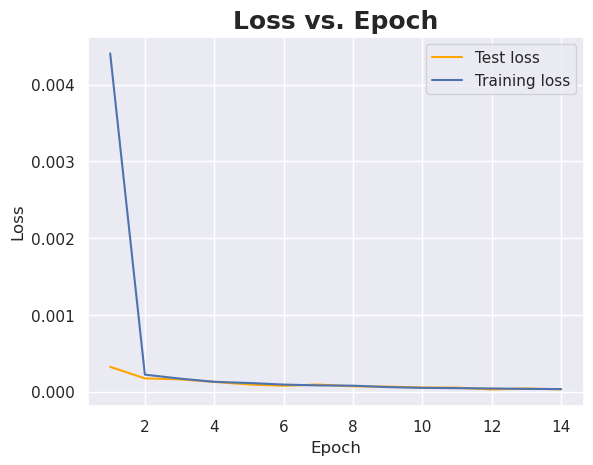

In [16]:
# summarize history for loss
train_loss = history.history['loss']
test_loss = history.history['val_loss']
x = list(range(1, len(test_loss) + 1))
plt.plot(x, test_loss, color = 'orange', label = 'Test loss')
plt.plot(x, train_loss, label = 'Training loss')
plt.legend()
plt.grid(visible=True)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epoch', weight='bold', fontsize=18)
plt.show()

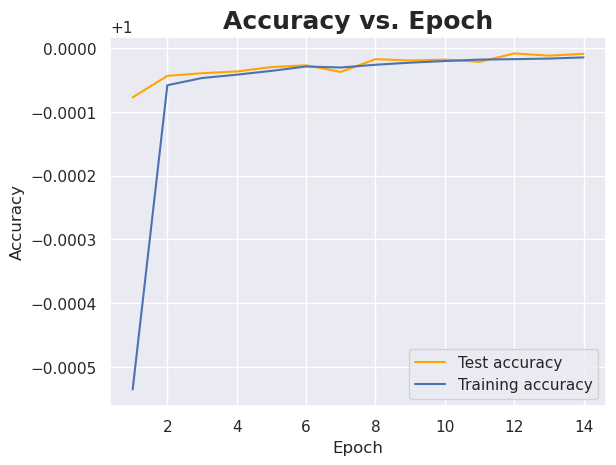

In [17]:
# summarize history for accuracy
train_acc = history.history['accuracy']
test_acc = history.history['val_accuracy']
x = list(range(1, len(test_acc) + 1))
plt.plot(x, test_acc, color = 'orange', label = 'Test accuracy')
plt.plot(x, train_acc, label = 'Training accuracy')
plt.legend()
plt.grid(visible=True)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epoch', weight='bold', fontsize=18)
plt.show()

45331/45331 ━━━━━━━━━━━━━━━━━━━━ 16s 339us/step


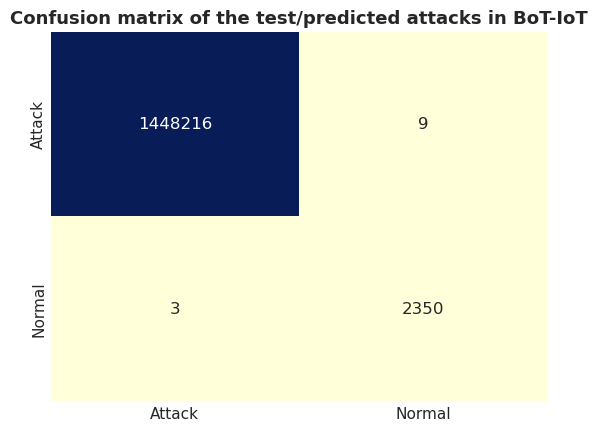

In [18]:
with tf.device('/GPU:0'):  # Use GPU 0    
    # Prediction
    predicted = model.predict(x_test)

    # Confusion matrix
    y_class = np.argmax(predicted, axis = 1) 
    y_test=y_test.to_numpy()
    y_check = np.argmax(y_test, axis = 1) 

    cmatrix = confusion_matrix(y_check, y_class)

    cmatrix_df = pd.DataFrame(cmatrix, index = ['Attack', 'Normal'], columns = ['Attack', 'Normal'])
    plt.title('Confusion matrix of the test/predicted attacks in BoT-IoT', weight='bold', fontsize=13)
    plt.tick_params(length=0)
    plt.xlabel('Attacks')
    plt.ylabel('Predicted Attacks')
    sns.heatmap(cmatrix_df, annot=True, cmap="YlGnBu", fmt="d", cbar=False)
    plt.show()

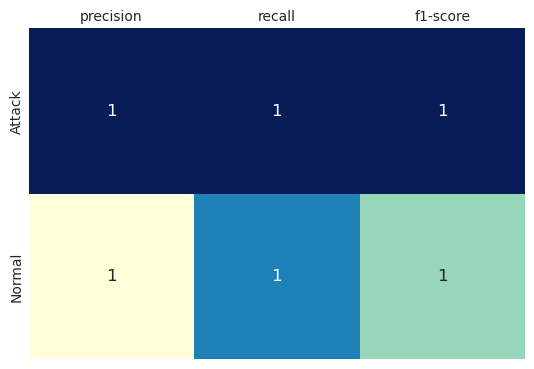

In [19]:
# Precision, Recall & F1-Score
#plt.figure(figsize=(15,8))
class_rep = classification_report(y_check, y_class, target_names=['Attack', 'Normal'], output_dict=True)
plt.tick_params(axis='both', which='major', labelsize=10, labelbottom = False, bottom=False, top = False, labeltop=True)
plt.tick_params(length=0)
sns.heatmap(pd.DataFrame(class_rep).iloc[:-1, :-3].T, cmap="YlGnBu", square=True, cbar=False, annot=True)
plt.show()

In [20]:
class_rep

{'Attack': {'precision': 0.9999979284900972,
  'recall': 0.9999937854960382,
  'f1-score': 0.9999958569887766,
  'support': 1448225.0},
 'Normal': {'precision': 0.9961848240779991,
  'recall': 0.9987250318742031,
  'f1-score': 0.9974533106960951,
  'support': 2353.0},
 'accuracy': 0.9999917274355464,
 'macro avg': {'precision': 0.9980913762840482,
  'recall': 0.9993594086851207,
  'f1-score': 0.9987245838424359,
  'support': 1450578.0},
 'weighted avg': {'precision': 0.9999917432076225,
  'recall': 0.9999917274355464,
  'f1-score': 0.999991732693891,
  'support': 1450578.0}}

# 2. UNSW-NB15-Train-Basic for training and UNSW-NB15-Test+ for validation
## Loading UNSW-NB15 Datasets

In [21]:
# Load UNSW-NB15-Train-Basic
data = pd.read_csv('../datasets/UNSW-NB15-Train-Basic.csv', low_memory=False)

# Select the 'proto' and 'state' values that I want
data = data.loc[(data['proto'] == 'tcp') | (data['proto'] =='udp') | (data['proto'] =='icmp') | (data['proto'] =='arp') | (data['proto'] =='ipv6-icmp') | (data['proto'] =='igmp') | (data['proto'] =='rarp'), :]
data = data.loc[(data['state'] == 'RST') | (data['state'] =='REQ') | (data['state'] =='INT') | (data['state'] =='FIN') | (data['state'] =='CON') | (data['state'] =='ECO') | (data['state'] =='ACC') | (data['state'] =='PAR'), :]

# Extracting dataset labels
data_labels=data[['label']]

# Drop the invalid features and select interested data features
data_features=data[['proto','srcip','sport','dstip','dsport','spkts','dpkts','sbytes','dbytes','state','stime','ltime','dur']]

In [22]:
"""PREPROCESSING"""

# Preprocess IP and ports features
# IP Source Address
data_features['srcip'] = data_features['srcip'].apply(lambda x: x.split(".")[-1])
data_features['srcip'] = data_features['srcip'].apply(lambda x: x.split(":")[-1])
data_features['srcip'] = data_features['srcip'].apply(lambda x: int(x, 16))

# IP Destination Address
data_features['dstip'] = data_features['dstip'].apply(lambda x: x.split(".")[-1])
data_features['dstip'] = data_features['dstip'].apply(lambda x: x.split(":")[-1])
data_features['dstip'] = data_features['dstip'].apply(lambda x: int(x, 16))

# Ports
data_features['sport'] = data_features['sport'].apply(lambda x: x.replace('0x','') if "0x" in str(x) else x)
data_features['dsport'] = data_features['dsport'].apply(lambda x: x.replace('0x','') if "0x" in str(x) else x)

# Convert all ports with 0 decimal, and HEX to DEC
data_features['sport'] = data_features['sport'].apply(lambda x: str(x)[:-2] if str(x)[-2:] == '.0' else str(x))
data_features['sport'] = data_features['sport'].apply(lambda x: -1 if str(x).isalpha()==True else int(x,16))

data_features['dsport'] = data_features['dsport'].apply(lambda x: str(x)[:-2] if str(x)[-2:] == '.0' else str(x))
data_features['dsport'] = data_features['dsport'].apply(lambda x: -1 if str(x).isalpha()==True else int(x,16))

# Convert field to int format
data_features['srcip'] = data_features['srcip'].astype(int)
data_features['sport'] = data_features['sport'].astype(int)
data_features['dstip'] = data_features['dstip'].astype(int)
data_features['dsport'] = data_features['dsport'].astype(int)

# Convert some fields to logarithmic
log1p_col = ['dur', 'sbytes', 'dbytes', 'spkts']

for col in log1p_col:
    data_features[col] = data_features[col].apply(np.log1p)
    
# Create a complementary field of attack & Transform to One hot encoding - LABELS
normal=data_labels['label']
normal=normal.replace(1,2)
normal=normal.replace(0,1)
normal=normal.replace(2,0)

# Insert the new column in data labels
data_labels.insert(1, 'normal', normal)
data_labels = pd.get_dummies(data_labels)

# Transform to One hot encoding - FEATURES
data_features=pd.get_dummies(data_features)

# Normalize all data features
data_features = StandardScaler().fit_transform(data_features)

#Add dimension to data features
data_features = np.expand_dims(data_features, axis=2)
data_features = np.expand_dims(data_features, axis=3)

x_train, y_train=data_features, data_labels

In [23]:
x_train.shape

(410556, 24, 1, 1)

In [24]:
# Load UNSW-NB15-Test+
data = pd.read_csv('../datasets/UNSW-NB15-Test+.csv', low_memory=False)

# Select the 'proto' and 'state' values that I want
data = data.loc[(data['proto'] == 'tcp') | (data['proto'] =='udp') | (data['proto'] =='icmp') | (data['proto'] =='arp') | (data['proto'] =='ipv6-icmp') | (data['proto'] =='igmp') | (data['proto'] =='rarp'), :]
data = data.loc[(data['state'] == 'RST') | (data['state'] =='REQ') | (data['state'] =='INT') | (data['state'] =='FIN') | (data['state'] =='CON') | (data['state'] =='ECO') | (data['state'] =='ACC') | (data['state'] =='PAR'), :]

# Extracting dataset labels
data_labels=data[['label']]

#Extracting dataset features
data_features=data[['proto','srcip','sport','dstip','dsport','spkts','dpkts','sbytes','dbytes','state','stime','ltime','dur']]

In [25]:
"""PREPROCESSING"""

# Preprocess IP and ports features
# IP Source Address
data_features['srcip'] = data_features['srcip'].apply(lambda x: x.split(".")[-1])
data_features['srcip'] = data_features['srcip'].apply(lambda x: x.split(":")[-1])
data_features['srcip'] = data_features['srcip'].apply(lambda x: int(x, 16))

# IP Destination Address
data_features['dstip'] = data_features['dstip'].apply(lambda x: x.split(".")[-1])
data_features['dstip'] = data_features['dstip'].apply(lambda x: x.split(":")[-1])
data_features['dstip'] = data_features['dstip'].apply(lambda x: int(x, 16))

# Ports
data_features['sport'] = data_features['sport'].apply(lambda x: x.replace('0x','') if "0x" in str(x) else x)
data_features['dsport'] = data_features['dsport'].apply(lambda x: x.replace('0x','') if "0x" in str(x) else x)

# Convert all ports with 0 decimal, and HEX to DEC
data_features['sport'] = data_features['sport'].apply(lambda x: str(x)[:-2] if str(x)[-2:] == '.0' else str(x))
data_features['sport'] = data_features['sport'].apply(lambda x: -1 if str(x).isalpha()==True else int(x,16))

data_features['dsport'] = data_features['dsport'].apply(lambda x: str(x)[:-2] if str(x)[-2:] == '.0' else str(x))
data_features['dsport'] = data_features['dsport'].apply(lambda x: -1 if str(x).isalpha()==True else int(x,16))

# Convert field to int format
data_features['srcip'] = data_features['srcip'].astype(int)
data_features['sport'] = data_features['sport'].astype(int)
data_features['dstip'] = data_features['dstip'].astype(int)
data_features['dsport'] = data_features['dsport'].astype(int)

# Convert some fields to logarithmic
log1p_col = ['dur', 'sbytes', 'dbytes', 'spkts']

for col in log1p_col:
    data_features[col] = data_features[col].apply(np.log1p)
    
# Create a complementary field of attack & Transform to One hot encoding - LABELS
normal=data_labels['label']
normal=normal.replace(1,2)
normal=normal.replace(0,1)
normal=normal.replace(2,0)

# Insert the new column in data labels
data_labels.insert(1, 'normal', normal)
data_labels = pd.get_dummies(data_labels)

# Transform to One hot encoding - FEATURES
data_features=pd.get_dummies(data_features)

# Generate 2 new columns to fit with training
auxCol=data_features['sbytes']
auxCol=0
data_features.insert(13, 'proto_igmp', auxCol, True)
data_features.insert(21, 'state_PAR', auxCol, True)

# Normalize all data features
data_features = StandardScaler().fit_transform(data_features)

#Add dimension to data features
data_features = np.expand_dims(data_features, axis=2)
data_features = np.expand_dims(data_features, axis=3)

x_test, y_test=data_features, data_labels

In [26]:
x_test.shape

(55052, 24, 1, 1)

## Load Pretrained Model
Loading pretrained model from BoT-IoT and freeze convolutional base

In [28]:
# Load model of BoT-IoT Dataset
pre_trained_model = load_model('../models/tmp/BoT-IoT_CNN_Detection.keras')

In [29]:
# Setting all layers to non trainable
pre_trained_model.trainable=False

In [30]:
# Removing the last 3 layers to get only the convolutional base
pre_trained_model.pop()
pre_trained_model.pop()
pre_trained_model.pop()

<Flatten name=flatten, built=True>

In [31]:
pre_trained_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 24, 1, 32)      │           352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 1, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 24, 1, 64)      │        20,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 24, 1, 64)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,429,326 (5.45 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 20,896 (81.62 KB)

 Optimizer params: 1,408,430 (5.37 MB)

## Transfer Learning
Creating the new model and training

In [32]:
# New model building
modelFE = models.Sequential()
modelFE.add(pre_trained_model)

modelFE.add(layers.Flatten())
modelFE.add(Dense(448, activation='relu'))
modelFE.add(layers.Dropout(0.4))
modelFE.add(Dense(224, activation='relu'))
modelFE.add(layers.Dropout(0.3))
modelFE.add(Dense(112, activation='relu'))
modelFE.add(layers.Dropout(0.3))
modelFE.add(Dense(2, activation='softmax'))

In [33]:
# Model summary
modelFE.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 24, 1, 64)      │        20,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 448)            │       688,576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 448)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 224)            │       100,576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 224)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 112)            │        25,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 112)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │           226 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 835,474 (3.19 MB)

 Trainable params: 814,578 (3.11 MB)

 Non-trainable params: 20,896 (81.62 KB)

In [34]:
# Early Stopping

filepath = '../models/tmp/TransferLearning_Detection.keras' # define where the model is saved
callbacks = [
        keras.callbacks.EarlyStopping(
            monitor = 'val_loss', # Use accuracy to monitor the model
            patience = 2 # Stop after 5 steps with lower accuracy
        ),
        keras.callbacks.ModelCheckpoint(
            filepath = filepath, # file where the checkpoint is saved
            monitor = 'val_loss', # Don't overwrite the saved model unless val_loss is worse
            save_best_only = True)]# Only save model if it is the best

In [35]:
with tf.device('/GPU:0'):  # Use GPU 0    
#Configure model training
    modelFE.compile(optimizer=tf.keras.optimizers.Adam(2e-5), loss='categorical_crossentropy', metrics=['accuracy'])
    history = modelFE.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=15,  batch_size=2048, callbacks=callbacks)
    history_1=history

Epoch 1/15


2025-03-19 22:59:59.959026: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1696', 2392 bytes spill stores, 2268 bytes spill loads

2025-03-19 23:00:00.036990: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1696', 2936 bytes spill stores, 2800 bytes spill loads



194/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7079 - loss: 0.6000

2025-03-19 23:00:01.487871: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1696', 4 bytes spill stores, 4 bytes spill loads

2025-03-19 23:00:01.843789: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1696', 12 bytes spill stores, 12 bytes spill loads



201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7112 - loss: 0.5964

2025-03-19 23:00:03.559463: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_83', 24 bytes spill stores, 24 bytes spill loads

2025-03-19 23:00:03.699495: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_83', 320 bytes spill stores, 320 bytes spill loads

2025-03-19 23:00:04.614313: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_83', 80 bytes spill stores, 80 bytes spill loads

2025-03-19 23:00:04.904792: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_83', 632 bytes spill stores, 624 bytes spill loads

2025-03-19 23:00:04.941204: I external/local_xla/xla/stream_exec

201/201 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - accuracy: 0.7116 - loss: 0.5959 - val_accuracy: 0.6503 - val_loss: 0.5392
Epoch 2/15
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9148 - loss: 0.2380 - val_accuracy: 0.9673 - val_loss: 0.1638
Epoch 3/15
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9789 - loss: 0.0873 - val_accuracy: 0.9845 - val_loss: 0.0884
Epoch 4/15
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9858 - loss: 0.0583 - val_accuracy: 0.9860 - val_loss: 0.0748
Epoch 5/15
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9885 - loss: 0.0482 - val_accuracy: 0.9865 - val_loss: 0.0714
Epoch 6/15
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9900 - loss: 0.0418 - val_accuracy: 0.9858 - val_loss: 0.0719
Epoch 7/15
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9908 - loss: 0.0389 - val_accuracy: 0.9848 - val_loss: 0.0745


## Loading Best model from Transfer Learning
Load and validate the final transfer learning model

In [37]:
# Load Transfer Learning model
modelFE = load_model('../models/tmp/TransferLearning_Detection.keras')

/home/deeplearning01/anaconda3/envs/TL_IDS/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [38]:
#Evaluate the model
results = modelFE.evaluate(x_test, y_test, verbose=0)
print("test loss, test acc:", results)

test loss, test acc: [0.07139793783426285, 0.98652184009552]


1721/1721 ━━━━━━━━━━━━━━━━━━━━ 1s 599us/step


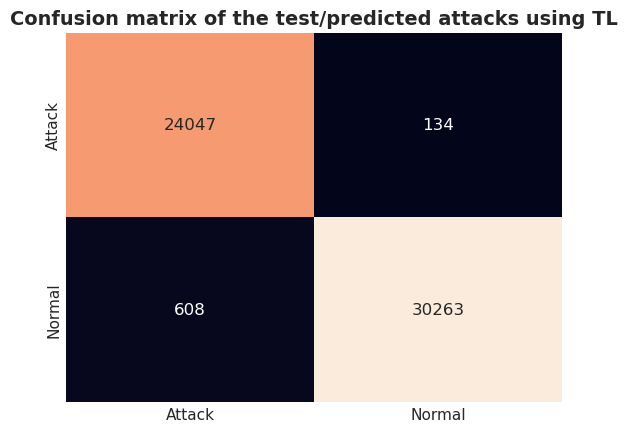

In [39]:
with tf.device('/GPU:0'):  # Use GPU 0    
    # Prediction
    predicted = modelFE.predict(x_test)

    # Confusion matrix
    y_class = np.argmax(predicted, axis = 1)
    y_test1=y_test
    y_test1=y_test1.to_numpy()
    y_check = np.argmax(y_test1, axis = 1) 

    cmatrix = confusion_matrix(y_check, y_class)

    cmatrix_df = pd.DataFrame(cmatrix, index = ['Attack', 'Normal'], columns = ['Attack', 'Normal'])
    plt.title('Confusion matrix of the test/predicted attacks using TL', weight='bold', fontsize=14)
    plt.tick_params(length=0)
    plt.xlabel('Attacks')
    plt.ylabel('Predicted Attacks')
    sns.heatmap(cmatrix_df, annot=True, fmt="d", cbar=False)
    plt.show()

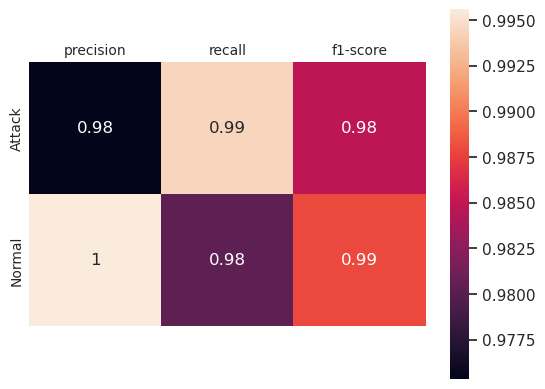

In [40]:
# Precision, Recall & F1-Score
class_rep = classification_report(y_check, y_class, target_names = ['Attack', 'Normal'], output_dict=True)
plt.tick_params(axis='both', which='major', labelsize=10, labelbottom = False, bottom=False, top = False, labeltop=True)
plt.tick_params(length=0)
sns.heatmap(pd.DataFrame(class_rep).iloc[:-1, :-3].T, square=True, cbar=True, annot=True)
plt.show()

In [41]:
class_rep

{'Attack': {'precision': 0.9753396876901237,
  'recall': 0.9944584591207973,
  'f1-score': 0.9848062904414776,
  'support': 24181.0},
 'Normal': {'precision': 0.9955916702306149,
  'recall': 0.9803051407469794,
  'f1-score': 0.9878892733564014,
  'support': 30871.0},
 'accuracy': 0.9865218339024922,
 'macro avg': {'precision': 0.9854656789603693,
  'recall': 0.9873817999338883,
  'f1-score': 0.9863477818989395,
  'support': 55052.0},
 'weighted avg': {'precision': 0.9866962043109097,
  'recall': 0.9865218339024922,
  'f1-score': 0.9865351062077825,
  'support': 55052.0}}

## Analysing Attack Detection

### Code

In [42]:
predicted

array([[9.5184702e-01, 4.8152920e-02],
       [9.6288776e-01, 3.7112221e-02],
       [8.2918429e-01, 1.7081569e-01],
       ...,
       [6.3183269e-04, 9.9936813e-01],
       [5.6419271e-04, 9.9943584e-01],
       [5.6619401e-04, 9.9943382e-01]], dtype=float32)

In [43]:
df = pd.DataFrame(predicted)
df.index = data.index

In [44]:
df['attack']=data['label']
df['category']=data['attack_cat']
df['normal']=data_labels['normal']

In [45]:
df.columns = ['pred_attack', 'pred_normal', 'attack', 'category', 'normal']

In [46]:
dff=df
df=pd.get_dummies(df)
df=round(df)

In [47]:
analysis=df.loc[df['category_analysis'] == 1]
analysis=analysis[['pred_attack', 'pred_normal', 'attack', 'normal']]
analysis_pred=analysis[['pred_attack','pred_normal']]
analysis_check=analysis[['attack','normal']]

backdoor=df.loc[df['category_backdoor'] == 1]
backdoor=backdoor[['pred_attack', 'pred_normal', 'attack', 'normal']]
backdoor_pred=backdoor[['pred_attack','pred_normal']]
backdoor_check=backdoor[['attack','normal']]

fuzzers=df.loc[df['category_fuzzers'] == 1]
fuzzers=fuzzers[['pred_attack', 'pred_normal', 'attack', 'normal']]
fuzzers_pred=fuzzers[['pred_attack','pred_normal']]
fuzzers_check=fuzzers[['attack','normal']]

normal=df.loc[df['category_normal'] == 1]
normal=normal[['pred_attack', 'pred_normal', 'attack', 'normal']]
normal_pred=normal[['pred_attack','pred_normal']]
normal_check=normal[['attack','normal']]

shellcode=df.loc[df['category_shellcode'] == 1]
shellcode=shellcode[['pred_attack', 'pred_normal', 'attack', 'normal']]
shellcode_pred=shellcode[['pred_attack','pred_normal']]
shellcode_check=shellcode[['attack','normal']]

worms=df.loc[df['category_worms'] == 1]
worms=worms[['pred_attack', 'pred_normal', 'attack', 'normal']]
worms_pred=worms[['pred_attack','pred_normal']]
worms_check=worms[['attack','normal']]

In [49]:
#Correctly detected
countdata=pd.DataFrame()
normal_c = normal['pred_normal'] * normal['normal']
analysis_c = analysis['pred_attack'] * analysis['attack']
backdoor_c = backdoor['pred_attack'] * backdoor['attack']
fuzzers_c = fuzzers['pred_attack'] * fuzzers['attack']
shellcode_c = shellcode['pred_attack'] * shellcode['attack']
worms_c = worms['pred_attack'] * worms['attack']


In [50]:
# Count 0 and 1
normal_c0 = (normal_c == 0).sum()
normal_c1 = len(normal) - normal_c0

analysis_c0 = (analysis_c == 0).sum()
analysis_c1 = len(analysis) - analysis_c0

backdoor_c0 = (backdoor_c == 0).sum()
backdoor_c1 = len(backdoor) - backdoor_c0

fuzzers_c0 = (fuzzers_c == 0).sum()
fuzzers_c1 = len(fuzzers) - fuzzers_c0

shellcode_c0 = (shellcode_c == 0).sum()
shellcode_c1 = len(shellcode) - shellcode_c0

worms_c0 = (worms_c == 0).sum()
worms_c1 = len(worms) - worms_c0

In [51]:
normal_0, normal_1 = normal_c0*100 / len(normal), normal_c1*100 / len(normal)
print("There are {:.2f} % of NO detected and {:.2f} % of detected samples".format(normal_0, normal_1))

There are 1.97 % of NO detected and 98.03 % of detected samples


In [52]:
analysis_0, analysis_1 = analysis_c0*100 / len(analysis), analysis_c1*100 / len(analysis)
print("There are {:.2f} % of NO detected and {:.2f} % of detected samples".format(analysis_0, analysis_1))

There are 0.00 % of NO detected and 100.00 % of detected samples


In [53]:
backdoor_0, backdoor_1 = backdoor_c0*100 / len(backdoor), backdoor_c1*100 / len(backdoor)
print("There are {:.2f} % of NO detected and {:.2f} % of detected samples".format(backdoor_0, backdoor_1))

There are 0.84 % of NO detected and 99.16 % of detected samples


In [54]:
fuzzers_0, fuzzers_1 = fuzzers_c0*100 / len(fuzzers), fuzzers_c1*100 / len(fuzzers)
print("There are {:.2f} % of NO detected and {:.2f} % of detected samples".format(fuzzers_0, fuzzers_1))

There are 0.28 % of NO detected and 99.72 % of detected samples


In [55]:
shellcode_0, shellcode_1 = shellcode_c0*100 / len(shellcode), shellcode_c1*100 / len(shellcode)
print("There are {:.2f} % of NO detected and {:.2f} % of detected samples".format(shellcode_0, shellcode_1))

There are 4.37 % of NO detected and 95.63 % of detected samples


In [56]:
worms_0, worms_1 = worms_c0*100 / len(worms), worms_c1*100 / len(worms)
print("There are {:.2f} % of NO detected and {:.2f} % of detected samples".format(worms_0, worms_1))

There are 2.87 % of NO detected and 97.13 % of detected samples


In [57]:
summary = pd.DataFrame({"Traffic":
                   ["Normal", "Analysis", "Backdoor", "Fuzzers", "Shellcode", "Worms"],
                   "Detected %": [normal_1, analysis_1, backdoor_1, fuzzers_1, shellcode_1, worms_1],
                   "No Detected %": [normal_0, analysis_0, backdoor_0, fuzzers_0, shellcode_0, worms_0],
                   "Detected Samples": [normal_c1, analysis_c1, backdoor_c1, fuzzers_c1, shellcode_c1, worms_c1],
                   "No Detected Samples": [normal_c0, analysis_c0, backdoor_c0, fuzzers_c0, shellcode_c0, worms_c0]})

In [58]:
dff['category_pred'] = np.where(((df['attack'] == 1) & (df['pred_attack'] == 1)) | ((df['normal'] == 1) & (df['pred_normal'] == 1)), 'Detected', 'No Detected')

In [59]:
data_plot=dff[['category', 'category_pred']]

In [60]:
data_plot

,category,category_pred
4,fuzzers,Detected
5,fuzzers,Detected
6,fuzzers,Detected
7,fuzzers,Detected
8,fuzzers,Detected
...,...,...
61869,normal,Detected
61870,normal,Detected
61871,normal,Detected
61872,normal,Detected


### Results

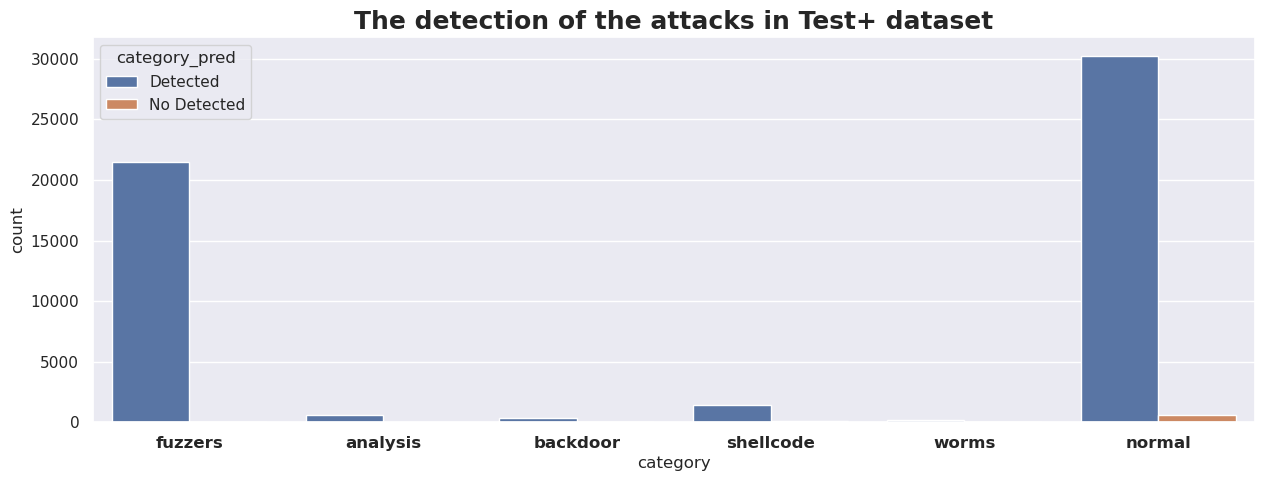

In [61]:
# Plotting target label distribution
plt.figure(figsize=(15,5))
sns.set_theme(style="darkgrid")
sns.countplot(x=data_plot['category'], data=data_plot, hue=data_plot['category_pred'])
plt.title('The detection of the attacks in Test+ dataset', weight='bold', fontsize='18')
plt.xticks(weight='bold', fontsize=12)
plt.show()

In [62]:
summary

,Traffic,Detected %,No Detected %,Detected Samples,No Detected Samples
0,Normal,98.030514,1.969486,30263,608
1,Analysis,100.000000,0.000000,622,0
2,Backdoor,99.159664,0.840336,354,3
3,Fuzzers,99.721151,0.278849,21457,60
4,Shellcode,95.632032,4.367968,1445,66
5,Worms,97.126437,2.873563,169,5


In [64]:
improve = pd.read_csv('../others/No_TransferLearning.csv')

In [65]:
improve['Detected %'] = summary['Detected %'] - improve['Detected %']
improve['Detected Samples'] = summary['Detected Samples'] - improve['Detected Samples']
del improve['No Detected %']
del improve['No Detected Samples']

improve.rename(columns = {'Detected %':'Detection Improvement %', 'Detected Samples':'Detected Samples Improvement'}, inplace = True)

In [66]:
improve

,Traffic,Detection Improvement %,Detected Samples Improvement
0,Normal,-1.515986,-468
1,Analysis,63.022508,392
2,Backdoor,66.946779,239
3,Fuzzers,56.750476,12211
4,Shellcode,22.832561,345
5,Worms,25.862069,45


# UNSW-NB15-Train-Basic for training and UNSW-NB15-Test for validation with NO TRANSFER LEARNING
## Loading UNSW-NB15 Datasets

In [67]:
# Load UNSW-NB15-Train-Basic
data = pd.read_csv('../datasets/UNSW-NB15-Train-Basic.csv', low_memory=False)

# Select the 'proto' and 'state' values that I want
data = data.loc[(data['proto'] == 'tcp') | (data['proto'] =='udp') | (data['proto'] =='icmp') | (data['proto'] =='arp') | (data['proto'] =='ipv6-icmp') | (data['proto'] =='igmp') | (data['proto'] =='rarp'), :]
data = data.loc[(data['state'] == 'RST') | (data['state'] =='REQ') | (data['state'] =='INT') | (data['state'] =='FIN') | (data['state'] =='CON') | (data['state'] =='ECO') | (data['state'] =='ACC') | (data['state'] =='PAR'), :]

# Extracting dataset labels
data_labels=data[['label']]

# Drop the invalid features and select interested data features
data_features=data[['proto','srcip','sport','dstip','dsport','spkts','dpkts','sbytes','dbytes','state','stime','ltime','dur']]

In [68]:
"""PREPROCESSING"""

# Preprocess IP and ports features
# IP Source Address
data_features['srcip'] = data_features['srcip'].apply(lambda x: x.split(".")[-1])
data_features['srcip'] = data_features['srcip'].apply(lambda x: x.split(":")[-1])
data_features['srcip'] = data_features['srcip'].apply(lambda x: int(x, 16))

# IP Destination Address
data_features['dstip'] = data_features['dstip'].apply(lambda x: x.split(".")[-1])
data_features['dstip'] = data_features['dstip'].apply(lambda x: x.split(":")[-1])
data_features['dstip'] = data_features['dstip'].apply(lambda x: int(x, 16))

# Ports
data_features['sport'] = data_features['sport'].apply(lambda x: x.replace('0x','') if "0x" in str(x) else x)
data_features['dsport'] = data_features['dsport'].apply(lambda x: x.replace('0x','') if "0x" in str(x) else x)

# Convert all ports with 0 decimal, and HEX to DEC
data_features['sport'] = data_features['sport'].apply(lambda x: str(x)[:-2] if str(x)[-2:] == '.0' else str(x))
data_features['sport'] = data_features['sport'].apply(lambda x: -1 if str(x).isalpha()==True else int(x,16))

data_features['dsport'] = data_features['dsport'].apply(lambda x: str(x)[:-2] if str(x)[-2:] == '.0' else str(x))
data_features['dsport'] = data_features['dsport'].apply(lambda x: -1 if str(x).isalpha()==True else int(x,16))

# Convert field to int format
data_features['srcip'] = data_features['srcip'].astype(int)
data_features['sport'] = data_features['sport'].astype(int)
data_features['dstip'] = data_features['dstip'].astype(int)
data_features['dsport'] = data_features['dsport'].astype(int)

# Convert some fields to logarithmic
log1p_col = ['dur', 'sbytes', 'dbytes', 'spkts']

for col in log1p_col:
    data_features[col] = data_features[col].apply(np.log1p)
    
# Create a complementary field of attack & Transform to One hot encoding - LABELS
normal=data_labels['label']
normal=normal.replace(1,2)
normal=normal.replace(0,1)
normal=normal.replace(2,0)

# Insert the new column in data labels
data_labels.insert(1, 'normal', normal)
data_labels = pd.get_dummies(data_labels)

# Transform to One hot encoding - FEATURES
data_features=pd.get_dummies(data_features)

# Normalize all data features
data_features = StandardScaler().fit_transform(data_features)

#Add dimension to data features
data_features = np.expand_dims(data_features, axis=2)
data_features = np.expand_dims(data_features, axis=3)

x_train, y_train=data_features, data_labels

In [69]:
x_train.shape

(410556, 24, 1, 1)

In [70]:
# Load UNSW-NB15
data = pd.read_csv('../datasets/UNSW-NB15-Test.csv', low_memory=False)

# Select the 'proto' and 'state' values that I want
data = data.loc[(data['proto'] == 'tcp') | (data['proto'] =='udp') | (data['proto'] =='icmp') | (data['proto'] =='arp') | (data['proto'] =='ipv6-icmp') | (data['proto'] =='igmp') | (data['proto'] =='rarp'), :]
data = data.loc[(data['state'] == 'RST') | (data['state'] =='REQ') | (data['state'] =='INT') | (data['state'] =='FIN') | (data['state'] =='CON') | (data['state'] =='ECO') | (data['state'] =='ACC') | (data['state'] =='PAR'), :]

# Extracting dataset labels
data_labels=data[['label']]

#Extracting dataset features
data_features=data[['proto','srcip','sport','dstip','dsport','spkts','dpkts','sbytes','dbytes','state','stime','ltime','dur']]

In [71]:
"""PREPROCESSING"""

# Preprocess IP and ports features
# IP Source Address
data_features['srcip'] = data_features['srcip'].apply(lambda x: x.split(".")[-1])
data_features['srcip'] = data_features['srcip'].apply(lambda x: x.split(":")[-1])
data_features['srcip'] = data_features['srcip'].apply(lambda x: int(x, 16))

# IP Destination Address
data_features['dstip'] = data_features['dstip'].apply(lambda x: x.split(".")[-1])
data_features['dstip'] = data_features['dstip'].apply(lambda x: x.split(":")[-1])
data_features['dstip'] = data_features['dstip'].apply(lambda x: int(x, 16))

# Ports
data_features['sport'] = data_features['sport'].apply(lambda x: x.replace('0x','') if "0x" in str(x) else x)
data_features['dsport'] = data_features['dsport'].apply(lambda x: x.replace('0x','') if "0x" in str(x) else x)

# Convert all ports with 0 decimal, and HEX to DEC
data_features['sport'] = data_features['sport'].apply(lambda x: str(x)[:-2] if str(x)[-2:] == '.0' else str(x))
data_features['sport'] = data_features['sport'].apply(lambda x: -1 if str(x).isalpha()==True else int(x,16))

data_features['dsport'] = data_features['dsport'].replace('-', -1)
data_features['dsport'] = data_features['dsport'].apply(lambda x: str(x)[:-2] if str(x)[-2:] == '.0' else str(x))
data_features['dsport'] = data_features['dsport'].apply(lambda x: -1 if str(x).isalpha()==True else int(x,16))

# Convert field to int format
data_features['srcip'] = data_features['srcip'].astype(int)
data_features['sport'] = data_features['sport'].astype(int)
data_features['dstip'] = data_features['dstip'].astype(int)
data_features['dsport'] = data_features['dsport'].astype(int)

# Convert some fields to logarithmic
log1p_col = ['dur', 'sbytes', 'dbytes', 'spkts']

for col in log1p_col:
    data_features[col] = data_features[col].apply(np.log1p)
    
# Create a complementary field of attack & Transform to One hot encoding - LABELS
normal=data_labels['label']
normal=normal.replace(1,2)
normal=normal.replace(0,1)
normal=normal.replace(2,0)

# Insert the new column in data labels
data_labels.insert(1, 'normal', normal)
data_labels = pd.get_dummies(data_labels)

# Transform to One hot encoding - FEATURES
data_features=pd.get_dummies(data_features)

# Normalize all data features
data_features = StandardScaler().fit_transform(data_features)

#Add dimension to data features
data_features = np.expand_dims(data_features, axis=2)
data_features = np.expand_dims(data_features, axis=3)

x_test, y_test=data_features, data_labels

In [72]:
x_test.shape

(602516, 24, 1, 1)

In [73]:
# Model building and definition
input_shape = (24,1,1)
model = models.Sequential()
model.add(layers.Conv2D(filters=32,  input_shape=input_shape, kernel_size=(1,10), activation='relu', padding='same'))
model.add(layers.MaxPooling2D(pool_size=(1, 2), padding='same'))
model.add(layers.Conv2D(filters=64,  input_shape=input_shape, kernel_size=(1,10), activation='relu', padding='same'))
model.add(layers.MaxPooling2D(pool_size=(1, 2), padding='same'))
model.add(layers.Flatten())
model.add(Dense(444, activation='relu'))
model.add(Dense(2, activation='softmax'))

# Model summary
model.summary()

/home/deeplearning01/anaconda3/envs/TL_IDS/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 24, 1, 32)      │           352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 24, 1, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 1, 64)      │        20,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 24, 1, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 444)            │       682,428 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 2)              │           890 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 704,214 (2.69 MB)

 Trainable params: 704,214 (2.69 MB)

 Non-trainable params: 0 (0.00 B)

In [74]:
# Early Stopping

filepath = '../models/tmp/TransferLearning_Detection_Full_NOTL.keras' # define where the model is saved
callbacks = [
        keras.callbacks.EarlyStopping(
            monitor = 'val_loss', # Use accuracy to monitor the model
            patience = 2 # Stop after 5 steps with lower accuracy
        ),
        keras.callbacks.ModelCheckpoint(
            filepath = filepath, # file where the checkpoint is saved
            monitor = 'val_loss', # Don't overwrite the saved model unless val_loss is worse
            save_best_only = True)]# Only save model if it is the best

In [75]:
with tf.device('/GPU:0'):  # Use GPU 0        
#Configure model training
    model.compile(optimizer=tf.keras.optimizers.Adam(5e-4), loss='categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=25,  batch_size=2048, callbacks=callbacks)
    history_1=history

Epoch 1/25
184/201 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9162 - loss: 0.2699

2025-03-19 23:04:26.156438: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_504', 56 bytes spill stores, 56 bytes spill loads



201/201 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.9206 - loss: 0.2564 - val_accuracy: 0.9912 - val_loss: 0.0404
Epoch 2/25
201/201 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9917 - loss: 0.0322 - val_accuracy: 0.9915 - val_loss: 0.0392
Epoch 3/25
201/201 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9921 - loss: 0.0281 - val_accuracy: 0.9901 - val_loss: 0.0411
Epoch 4/25
201/201 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9922 - loss: 0.0278 - val_accuracy: 0.9877 - val_loss: 0.0440


In [78]:
# Load Transfer Learning model
model = load_model('../models/tmp/TransferLearning_Detection_Full_NOTL.keras')

In [79]:
#Evaluate the model
results = model.evaluate(x_test, y_test, verbose=0)
print("test loss, test acc:", results)

test loss, test acc: [0.03916621953248978, 0.9915006160736084]


18829/18829 ━━━━━━━━━━━━━━━━━━━━ 7s 343us/step


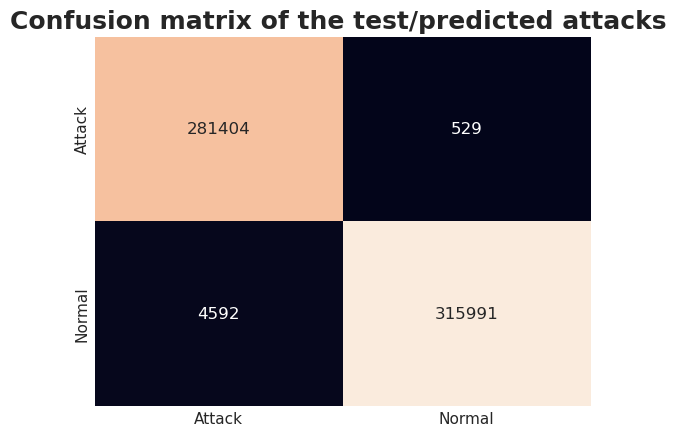

In [80]:
with tf.device('/GPU:0'):  # Use GPU 0    
    
# Prediction
    predicted = model.predict(x_test)

    # Confusion matrix
    y_class = np.argmax(predicted, axis = 1)
    y_test1=y_test
    y_test1=y_test1.to_numpy()
    y_check = np.argmax(y_test1, axis = 1) 

    cmatrix = confusion_matrix(y_check, y_class)

    cmatrix_df = pd.DataFrame(cmatrix, index = ['Attack', 'Normal'], columns = ['Attack', 'Normal'])
    plt.title('Confusion matrix of the test/predicted attacks ', weight='bold', fontsize=18)
    plt.tick_params(length=0)
    plt.xlabel('Attacks')
    plt.ylabel('Predicted Attacks')
    sns.heatmap(cmatrix_df, annot=True, fmt="d", cbar=False)
    plt.show()

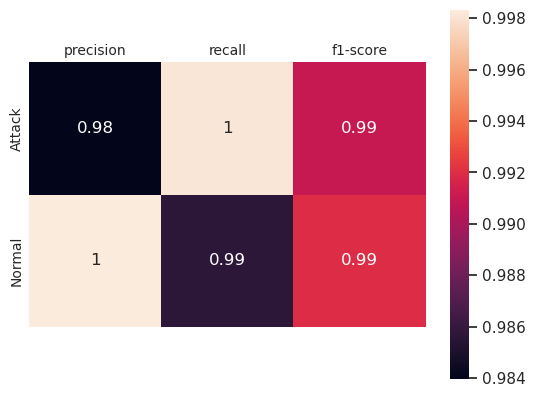

In [81]:
# Precision, Recall & F1-Score
class_rep = classification_report(y_check, y_class, target_names = ['Attack', 'Normal'], output_dict=True)
plt.tick_params(axis='both', which='major', labelsize=10, labelbottom = False, bottom=False, top = False, labeltop=True)
plt.tick_params(length=0)
sns.heatmap(pd.DataFrame(class_rep).iloc[:-1, :-3].T, square=True, cbar=True, annot=True)
plt.show()

In [82]:
class_rep

{'Attack': {'precision': 0.983943831382257,
  'recall': 0.9981236676799098,
  'f1-score': 0.9909830278080535,
  'support': 281933.0},
 'Normal': {'precision': 0.9983286996082396,
  'recall': 0.9856760963619405,
  'f1-score': 0.991962053231581,
  'support': 320583.0},
 'accuracy': 0.9915006406468874,
 'macro avg': {'precision': 0.9911362654952482,
  'recall': 0.9918998820209252,
  'f1-score': 0.9914725405198173,
  'support': 602516.0},
 'weighted avg': {'precision': 0.9915976434146181,
  'recall': 0.9915006406468874,
  'f1-score': 0.9915039416217127,
  'support': 602516.0}}

## Analysing Attack Detection

### Code

In [83]:
predicted

array([[8.7819940e-01, 1.2180056e-01],
       [9.9216378e-01, 7.8362534e-03],
       [9.2082196e-01, 7.9177998e-02],
       ...,
       [2.6009098e-04, 9.9973994e-01],
       [4.7706984e-05, 9.9995232e-01],
       [1.5459080e-04, 9.9984539e-01]], dtype=float32)

In [84]:
df = pd.DataFrame(predicted)
df.index = data.index

In [85]:
df['attack']=data['label']
df['category']=data['attack_cat']
df['normal']=data_labels['normal']

In [86]:
df.columns = ['pred_attack', 'pred_normal', 'attack', 'category', 'normal']

In [87]:
dff=df
df=pd.get_dummies(df)
df=round(df)

In [88]:
analysis=df.loc[df['category_analysis'] == 1]
analysis=analysis[['pred_attack', 'pred_normal', 'attack', 'normal']]
analysis_pred=analysis[['pred_attack','pred_normal']]
analysis_check=analysis[['attack','normal']]

backdoor=df.loc[df['category_backdoor'] == 1]
backdoor=backdoor[['pred_attack', 'pred_normal', 'attack', 'normal']]
backdoor_pred=backdoor[['pred_attack','pred_normal']]
backdoor_check=backdoor[['attack','normal']]

fuzzers=df.loc[df['category_fuzzers'] == 1]
fuzzers=fuzzers[['pred_attack', 'pred_normal', 'attack', 'normal']]
fuzzers_pred=fuzzers[['pred_attack','pred_normal']]
fuzzers_check=fuzzers[['attack','normal']]

normal=df.loc[df['category_normal'] == 1]
normal=normal[['pred_attack', 'pred_normal', 'attack', 'normal']]
normal_pred=normal[['pred_attack','pred_normal']]
normal_check=normal[['attack','normal']]

shellcode=df.loc[df['category_shellcode'] == 1]
shellcode=shellcode[['pred_attack', 'pred_normal', 'attack', 'normal']]
shellcode_pred=shellcode[['pred_attack','pred_normal']]
shellcode_check=shellcode[['attack','normal']]

worms=df.loc[df['category_worms'] == 1]
worms=worms[['pred_attack', 'pred_normal', 'attack', 'normal']]
worms_pred=worms[['pred_attack','pred_normal']]
worms_check=worms[['attack','normal']]

generic=df.loc[df['category_generic'] == 1]
generic=generic[['pred_attack', 'pred_normal', 'attack', 'normal']]
generic_pred=generic[['pred_attack','pred_normal']]
generic_check=generic[['attack','normal']]

exploits=df.loc[df['category_exploits'] == 1]
exploits=exploits[['pred_attack', 'pred_normal', 'attack', 'normal']]
exploits_pred=exploits[['pred_attack','pred_normal']]
exploits_check=exploits[['attack','normal']]

reconnaissance=df.loc[df['category_reconnaissance'] == 1]
reconnaissance=reconnaissance[['pred_attack', 'pred_normal', 'attack', 'normal']]
reconnaissance_pred=reconnaissance[['pred_attack','pred_normal']]
reconnaissance_check=reconnaissance[['attack','normal']]

dos=df.loc[df['category_dos'] == 1]
dos=dos[['pred_attack', 'pred_normal', 'attack', 'normal']]
dos_pred=dos[['pred_attack','pred_normal']]
dos_check=dos[['attack','normal']]

In [89]:
#Correctly detected
countdata=pd.DataFrame()
normal_c = normal['pred_normal'] * normal['normal']
analysis_c = analysis['pred_attack'] * analysis['attack']
backdoor_c = backdoor['pred_attack'] * backdoor['attack']
fuzzers_c = fuzzers['pred_attack'] * fuzzers['attack']
shellcode_c = shellcode['pred_attack'] * shellcode['attack']
worms_c = worms['pred_attack'] * worms['attack']
generic_c = generic['pred_attack'] * generic['attack']
exploits_c = exploits['pred_attack'] * exploits['attack']
reconnaissance_c = reconnaissance['pred_attack'] * reconnaissance['attack']
dos_c = dos['pred_attack'] * dos['attack']

In [90]:
# Count 0 and 1
normal_c0 = (normal_c == 0).sum()
normal_c1 = len(normal) - normal_c0

analysis_c0 = (analysis_c == 0).sum()
analysis_c1 = len(analysis) - analysis_c0

backdoor_c0 = (backdoor_c == 0).sum()
backdoor_c1 = len(backdoor) - backdoor_c0

fuzzers_c0 = (fuzzers_c == 0).sum()
fuzzers_c1 = len(fuzzers) - fuzzers_c0

shellcode_c0 = (shellcode_c == 0).sum()
shellcode_c1 = len(shellcode) - shellcode_c0

worms_c0 = (worms_c == 0).sum()
worms_c1 = len(worms) - worms_c0

generic_c0 = (generic_c == 0).sum()
generic_c1 = len(generic) - generic_c0

exploits_c0 = (exploits_c == 0).sum()
exploits_c1 = len(exploits) - exploits_c0

reconnaissance_c0 = (reconnaissance_c == 0).sum()
reconnaissance_c1 = len(reconnaissance) - reconnaissance_c0

dos_c0 = (dos_c == 0).sum()
dos_c1 = len(dos) - dos_c0

In [91]:
normal_0, normal_1 = normal_c0*100 / len(normal), normal_c1*100 / len(normal)
print("There are {:.2f} % of NO detected and {:.2f} % of detected samples".format(normal_0, normal_1))

There are 1.43 % of NO detected and 98.57 % of detected samples


In [92]:
analysis_0, analysis_1 = analysis_c0*100 / len(analysis), analysis_c1*100 / len(analysis)
print("There are {:.2f} % of NO detected and {:.2f} % of detected samples".format(analysis_0, analysis_1))

There are 0.80 % of NO detected and 99.20 % of detected samples


In [93]:
backdoor_0, backdoor_1 = backdoor_c0*100 / len(backdoor), backdoor_c1*100 / len(backdoor)
print("There are {:.2f} % of NO detected and {:.2f} % of detected samples".format(backdoor_0, backdoor_1))

There are 0.28 % of NO detected and 99.72 % of detected samples


In [94]:
fuzzers_0, fuzzers_1 = fuzzers_c0*100 / len(fuzzers), fuzzers_c1*100 / len(fuzzers)
print("There are {:.2f} % of NO detected and {:.2f} % of detected samples".format(fuzzers_0, fuzzers_1))

There are 2.02 % of NO detected and 97.98 % of detected samples


In [95]:
shellcode_0, shellcode_1 = shellcode_c0*100 / len(shellcode), shellcode_c1*100 / len(shellcode)
print("There are {:.2f} % of NO detected and {:.2f} % of detected samples".format(shellcode_0, shellcode_1))

There are 0.20 % of NO detected and 99.80 % of detected samples


In [96]:
worms_0, worms_1 = worms_c0*100 / len(worms), worms_c1*100 / len(worms)
print("There are {:.2f} % of NO detected and {:.2f} % of detected samples".format(worms_0, worms_1))

There are 1.15 % of NO detected and 98.85 % of detected samples


In [97]:
generic_0, generic_1 = generic_c0*100 / len(generic), generic_c1*100 / len(generic)
print("There are {:.2f} % of NO detected and {:.2f} % of detected samples".format(generic_0, generic_1))

There are 0.01 % of NO detected and 99.99 % of detected samples


In [98]:
exploits_0, exploits_1 = exploits_c0*100 / len(exploits), exploits_c1*100 / len(exploits)
print("There are {:.2f} % of NO detected and {:.2f} % of detected samples".format(exploits_0, exploits_1))

There are 0.18 % of NO detected and 99.82 % of detected samples


In [99]:
reconnaissance_0, reconnaissance_1 = reconnaissance_c0*100 / len(reconnaissance), reconnaissance_c1*100 / len(reconnaissance)
print("There are {:.2f} % of NO detected and {:.2f} % of detected samples".format(reconnaissance_0, reconnaissance_1))

There are 0.06 % of NO detected and 99.94 % of detected samples


In [100]:
dos_0, dos_1 = dos_c0*100 / len(dos), dos_c1*100 / len(dos)
print("There are {:.2f} % of NO detected and {:.2f} % of detected samples".format(dos_0, dos_1))

There are 0.18 % of NO detected and 99.82 % of detected samples


In [101]:
summary = pd.DataFrame({"Traffic":
                   ["Normal", "Analysis", "Backdoor", "Fuzzers", "Shellcode", "Worms", "Generic", "Exploits", "Reconnaissance", "DoS"],
                   "Detected %": [normal_1, analysis_1, backdoor_1, fuzzers_1, shellcode_1, worms_1, generic_1, exploits_1, reconnaissance_1, dos_1],
                   "No Detected %": [normal_0, analysis_0, backdoor_0, fuzzers_0, shellcode_0, worms_0, generic_0, exploits_0, reconnaissance_0, dos_0],
                   "Detected Samples": [normal_c1, analysis_c1, backdoor_c1, fuzzers_c1, shellcode_c1, worms_c1, generic_c1, exploits_c1, reconnaissance_c1, dos_c1],
                   "No Detected Samples": [normal_c0, analysis_c0, backdoor_c0, fuzzers_c0, shellcode_c0, worms_c0, generic_c0, exploits_c0, reconnaissance_c0, dos_c0]})

In [102]:
dff['category_pred'] = np.where(((df['attack'] == 1) & (df['pred_attack'] == 1)) | ((df['normal'] == 1) & (df['pred_normal'] == 1)), 'Detected', 'No Detected')

In [103]:
data_plot=dff[['category', 'category_pred']]

In [104]:
data_plot

,category,category_pred
0,exploits,Detected
1,exploits,Detected
2,reconnaissance,Detected
3,exploits,Detected
4,exploits,Detected
...,...,...
642561,normal,Detected
642562,normal,Detected
642563,normal,Detected
642564,normal,Detected


### Results

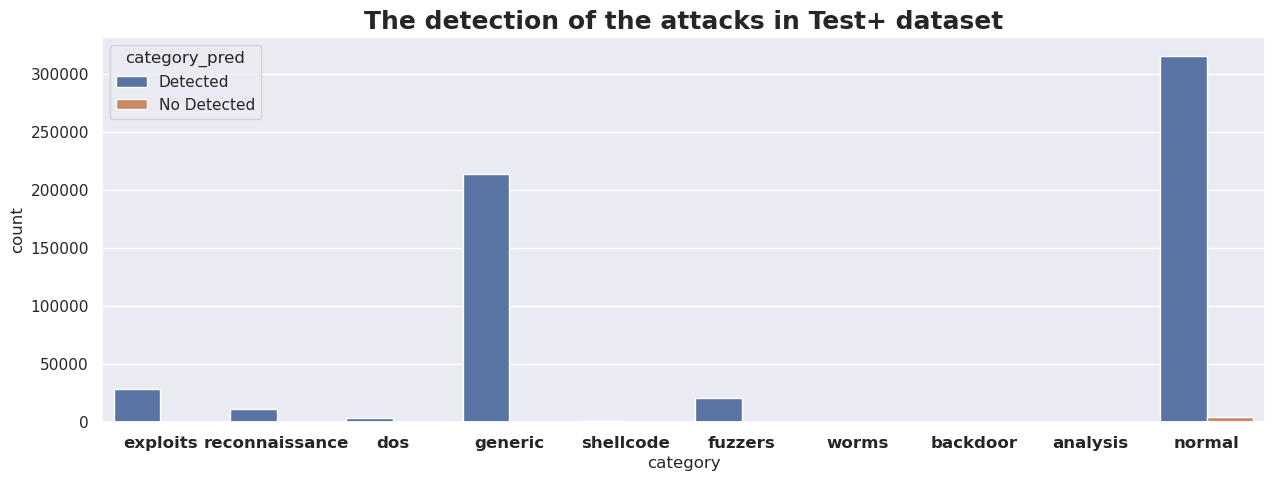

In [105]:
# Plotting target label distribution
plt.figure(figsize=(15,5))
sns.set_theme(style="darkgrid")
sns.countplot(x=data_plot['category'], data=data_plot, hue=data_plot['category_pred'])
plt.title('The detection of the attacks in Test+ dataset', weight='bold', fontsize='18')
plt.xticks(weight='bold', fontsize=12)
plt.show()

In [106]:
summary

,Traffic,Detected %,No Detected %,Detected Samples,No Detected Samples
0,Normal,98.567610,1.432390,315991,4592
1,Analysis,99.196141,0.803859,617,5
2,Backdoor,99.719888,0.280112,356,1
3,Fuzzers,97.982990,2.017010,21083,434
4,Shellcode,99.801456,0.198544,1508,3
5,Worms,98.850575,1.149425,172,2
6,Generic,99.991578,0.008422,213700,18
7,Exploits,99.816365,0.183635,28265,52
8,Reconnaissance,99.940948,0.059052,11847,7
9,DoS,99.818794,0.181206,3856,7


In [107]:
summary.to_csv('../others/No_TransferLearningFull.csv', index=False)

# UNSW-NB15-Train-Basic for training and UNSW-NB15 for validation using TRANSFER LEARNING
## Loading UNSW-NB15 Datasets

In [108]:
# Load UNSW-NB15-Train-Basic
data = pd.read_csv('../datasets/UNSW-NB15-Train-Basic.csv', low_memory=False)

# Select the 'proto' and 'state' values that I want
data = data.loc[(data['proto'] == 'tcp') | (data['proto'] =='udp') | (data['proto'] =='icmp') | (data['proto'] =='arp') | (data['proto'] =='ipv6-icmp') | (data['proto'] =='igmp') | (data['proto'] =='rarp'), :]
data = data.loc[(data['state'] == 'RST') | (data['state'] =='REQ') | (data['state'] =='INT') | (data['state'] =='FIN') | (data['state'] =='CON') | (data['state'] =='ECO') | (data['state'] =='ACC') | (data['state'] =='PAR'), :]

# Extracting dataset labels
data_labels=data[['label']]

# Drop the invalid features and select interested data features
data_features=data[['proto','srcip','sport','dstip','dsport','spkts','dpkts','sbytes','dbytes','state','stime','ltime','dur']]

In [109]:
"""PREPROCESSING"""

# Preprocess IP and ports features
# IP Source Address
data_features['srcip'] = data_features['srcip'].apply(lambda x: x.split(".")[-1])
data_features['srcip'] = data_features['srcip'].apply(lambda x: x.split(":")[-1])
data_features['srcip'] = data_features['srcip'].apply(lambda x: int(x, 16))

# IP Destination Address
data_features['dstip'] = data_features['dstip'].apply(lambda x: x.split(".")[-1])
data_features['dstip'] = data_features['dstip'].apply(lambda x: x.split(":")[-1])
data_features['dstip'] = data_features['dstip'].apply(lambda x: int(x, 16))

# Ports
data_features['sport'] = data_features['sport'].apply(lambda x: x.replace('0x','') if "0x" in str(x) else x)
data_features['dsport'] = data_features['dsport'].apply(lambda x: x.replace('0x','') if "0x" in str(x) else x)

# Convert all ports with 0 decimal, and HEX to DEC
data_features['sport'] = data_features['sport'].apply(lambda x: str(x)[:-2] if str(x)[-2:] == '.0' else str(x))
data_features['sport'] = data_features['sport'].apply(lambda x: -1 if str(x).isalpha()==True else int(x,16))

data_features['dsport'] = data_features['dsport'].apply(lambda x: str(x)[:-2] if str(x)[-2:] == '.0' else str(x))
data_features['dsport'] = data_features['dsport'].apply(lambda x: -1 if str(x).isalpha()==True else int(x,16))

# Convert field to int format
data_features['srcip'] = data_features['srcip'].astype(int)
data_features['sport'] = data_features['sport'].astype(int)
data_features['dstip'] = data_features['dstip'].astype(int)
data_features['dsport'] = data_features['dsport'].astype(int)

# Convert some fields to logarithmic
log1p_col = ['dur', 'sbytes', 'dbytes', 'spkts']

for col in log1p_col:
    data_features[col] = data_features[col].apply(np.log1p)
    
# Create a complementary field of attack & Transform to One hot encoding - LABELS
normal=data_labels['label']
normal=normal.replace(1,2)
normal=normal.replace(0,1)
normal=normal.replace(2,0)

# Insert the new column in data labels
data_labels.insert(1, 'normal', normal)
data_labels = pd.get_dummies(data_labels)

# Transform to One hot encoding - FEATURES
data_features=pd.get_dummies(data_features)

# Normalize all data features
data_features = StandardScaler().fit_transform(data_features)

#Add dimension to data features
data_features = np.expand_dims(data_features, axis=2)
data_features = np.expand_dims(data_features, axis=3)

x_train, y_train=data_features, data_labels

In [110]:
x_train.shape

(410556, 24, 1, 1)

In [112]:
# Load UNSW-NB15-Test+
data = pd.read_csv('../datasets/UNSW-NB15-Test.csv', low_memory=False)

# Select the 'proto' and 'state' values that I want
data = data.loc[(data['proto'] == 'tcp') | (data['proto'] =='udp') | (data['proto'] =='icmp') | (data['proto'] =='arp') | (data['proto'] =='ipv6-icmp') | (data['proto'] =='igmp') | (data['proto'] =='rarp'), :]
data = data.loc[(data['state'] == 'RST') | (data['state'] =='REQ') | (data['state'] =='INT') | (data['state'] =='FIN') | (data['state'] =='CON') | (data['state'] =='ECO') | (data['state'] =='ACC') | (data['state'] =='PAR'), :]

# Extracting dataset labels
data_labels=data[['label']]

#Extracting dataset features
data_features=data[['proto','srcip','sport','dstip','dsport','spkts','dpkts','sbytes','dbytes','state','stime','ltime','dur']]

In [113]:
"""PREPROCESSING"""

# Preprocess IP and ports features
# IP Source Address
data_features['srcip'] = data_features['srcip'].apply(lambda x: x.split(".")[-1])
data_features['srcip'] = data_features['srcip'].apply(lambda x: x.split(":")[-1])
data_features['srcip'] = data_features['srcip'].apply(lambda x: int(x, 16))

# IP Destination Address
data_features['dstip'] = data_features['dstip'].apply(lambda x: x.split(".")[-1])
data_features['dstip'] = data_features['dstip'].apply(lambda x: x.split(":")[-1])
data_features['dstip'] = data_features['dstip'].apply(lambda x: int(x, 16))

# Ports
data_features['sport'] = data_features['sport'].apply(lambda x: x.replace('0x','') if "0x" in str(x) else x)
data_features['dsport'] = data_features['dsport'].apply(lambda x: x.replace('0x','') if "0x" in str(x) else x)

# Convert all ports with 0 decimal, and HEX to DEC
data_features['sport'] = data_features['sport'].apply(lambda x: str(x)[:-2] if str(x)[-2:] == '.0' else str(x))
data_features['sport'] = data_features['sport'].apply(lambda x: -1 if str(x).isalpha()==True else int(x,16))

data_features['dsport'] = data_features['dsport'].replace('-', -1)
data_features['dsport'] = data_features['dsport'].apply(lambda x: str(x)[:-2] if str(x)[-2:] == '.0' else str(x))
data_features['dsport'] = data_features['dsport'].apply(lambda x: -1 if str(x).isalpha()==True else int(x,16))

# Convert field to int format
data_features['srcip'] = data_features['srcip'].astype(int)
data_features['sport'] = data_features['sport'].astype(int)
data_features['dstip'] = data_features['dstip'].astype(int)
data_features['dsport'] = data_features['dsport'].astype(int)

# Convert some fields to logarithmic
log1p_col = ['dur', 'sbytes', 'dbytes', 'spkts']

for col in log1p_col:
    data_features[col] = data_features[col].apply(np.log1p)
    
# Create a complementary field of attack & Transform to One hot encoding - LABELS
normal=data_labels['label']
normal=normal.replace(1,2)
normal=normal.replace(0,1)
normal=normal.replace(2,0)

# Insert the new column in data labels
data_labels.insert(1, 'normal', normal)
data_labels = pd.get_dummies(data_labels)

# Transform to One hot encoding - FEATURES
data_features=pd.get_dummies(data_features)

# Normalize all data features
data_features = StandardScaler().fit_transform(data_features)

#Add dimension to data features
data_features = np.expand_dims(data_features, axis=2)
data_features = np.expand_dims(data_features, axis=3)

x_test, y_test=data_features, data_labels

In [ ]:
x_test.shape

## Load Pretrained Model
Loading pretrained model from BoT-IoT and freeze convolutional base

In [114]:
# Load model of BoT-IoT Dataset
pre_trained_model = load_model('../models/tmp/BoT-IoT_CNN_Detection.keras')

In [115]:
# Setting all layers to non trainable
pre_trained_model.trainable=False

In [116]:
# Removing the last 3 layers to get only the convolutional base
pre_trained_model.pop()
pre_trained_model.pop()
pre_trained_model.pop()

<Flatten name=flatten, built=True>

In [117]:
pre_trained_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 24, 1, 32)      │           352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 1, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 24, 1, 64)      │        20,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 24, 1, 64)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,429,326 (5.45 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 20,896 (81.62 KB)

 Optimizer params: 1,408,430 (5.37 MB)

## Transfer Learning
Creating the new model and training

In [118]:
# New model building
modelFE = models.Sequential()
modelFE.add(pre_trained_model)

modelFE.add(layers.Flatten())
modelFE.add(Dense(448, activation='relu'))
modelFE.add(layers.Dropout(0.4))
modelFE.add(Dense(224, activation='relu'))
modelFE.add(layers.Dropout(0.3))
modelFE.add(Dense(112, activation='relu'))
modelFE.add(layers.Dropout(0.3))
modelFE.add(Dense(2, activation='softmax'))

In [119]:
# Model summary
modelFE.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 24, 1, 64)      │        20,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 448)            │       688,576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 448)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 224)            │       100,576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 224)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 112)            │        25,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 112)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 2)              │           226 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 835,474 (3.19 MB)

 Trainable params: 814,578 (3.11 MB)

 Non-trainable params: 20,896 (81.62 KB)

In [120]:
# Early Stopping

filepath = '../models/tmp/TransferLearning_Detection_Full.keras' # define where the model is saved
callbacks = [
        keras.callbacks.EarlyStopping(
            monitor = 'val_loss', # Use accuracy to monitor the model
            patience = 2 # Stop after 5 steps with lower accuracy
        ),
        keras.callbacks.ModelCheckpoint(
            filepath = filepath, # file where the checkpoint is saved
            monitor = 'val_loss', # Don't overwrite the saved model unless val_loss is worse
            save_best_only = True)]# Only save model if it is the best

In [121]:
with tf.device('/GPU:0'):  # Use GPU 0    
    #Configure model training
    epochs=25
    modelFE.compile(optimizer=tf.keras.optimizers.Adam(2e-5), loss='categorical_crossentropy', metrics=['accuracy'])
    history = modelFE.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=epochs,  batch_size=2048, callbacks=callbacks)
    history_1=history
    e=epochs

Epoch 1/25
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7194 - loss: 0.5763

2025-03-19 23:10:45.381447: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_83', 80 bytes spill stores, 80 bytes spill loads

2025-03-19 23:10:45.638026: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_83', 632 bytes spill stores, 624 bytes spill loads



201/201 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.7199 - loss: 0.5758 - val_accuracy: 0.8751 - val_loss: 0.2618
Epoch 2/25
201/201 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9319 - loss: 0.2170 - val_accuracy: 0.9835 - val_loss: 0.0741
Epoch 3/25
201/201 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9808 - loss: 0.0827 - val_accuracy: 0.9885 - val_loss: 0.0517
Epoch 4/25
201/201 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9869 - loss: 0.0569 - val_accuracy: 0.9896 - val_loss: 0.0457
Epoch 5/25
201/201 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9888 - loss: 0.0478 - val_accuracy: 0.9900 - val_loss: 0.0416
Epoch 6/25
201/201 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9896 - loss: 0.0435 - val_accuracy: 0.9903 - val_loss: 0.0386
Epoch 7/25
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9908 - loss: 0.0386 - val_accuracy: 0.9913 - val_loss: 0.0368
Epoch 8/25
201/201 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9914 - loss: 0.0366 - val_accuracy: 0.9915 - val

## Loading Best model from Transfer Learning
Load and validate the final transfer learning model

In [126]:
# Load Transfer Learning model
modelFE = load_model('../models/tmp/TransferLearning_Detection_Full.keras')

/home/deeplearning01/anaconda3/envs/TL_IDS/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [127]:
#Evaluate the model
results = modelFE.evaluate(x_test, y_test, verbose=0)
print("test loss, test acc:", results)

test loss, test acc: [0.03470169007778168, 0.9917014837265015]


18829/18829 ━━━━━━━━━━━━━━━━━━━━ 7s 373us/step


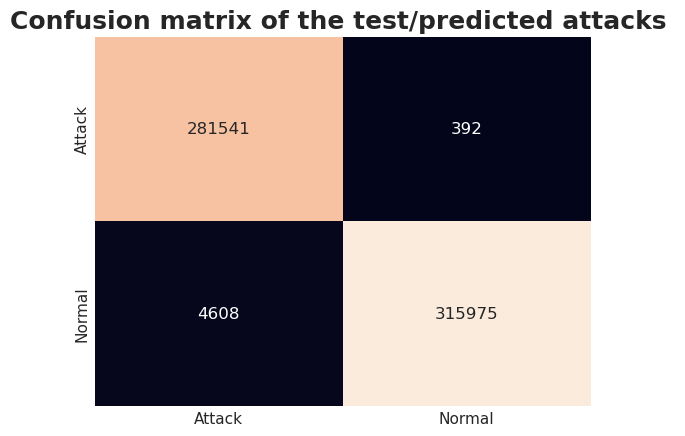

In [128]:
with tf.device('/GPU:0'):  # Use GPU 0    
    # Prediction
    predicted = modelFE.predict(x_test)

    # Confusion matrix
    y_class = np.argmax(predicted, axis = 1)
    y_test1=y_test
    y_test1=y_test1.to_numpy()
    y_check = np.argmax(y_test1, axis = 1) 

    cmatrix = confusion_matrix(y_check, y_class)

    cmatrix_df = pd.DataFrame(cmatrix, index = ['Attack', 'Normal'], columns = ['Attack', 'Normal'])
    plt.title('Confusion matrix of the test/predicted attacks ', weight='bold', fontsize=18)
    plt.tick_params(length=0)
    plt.xlabel('Attacks')
    plt.ylabel('Predicted Attacks')
    sns.heatmap(cmatrix_df, annot=True, fmt="d", cbar=False)
    plt.show()

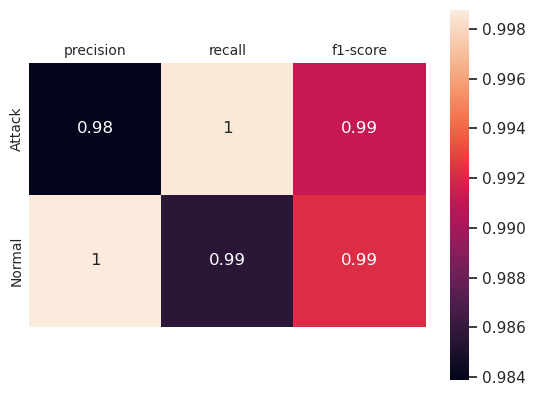

In [129]:
# Precision, Recall & F1-Score
class_rep = classification_report(y_check, y_class, target_names = ['Attack', 'Normal'], output_dict=True)
plt.tick_params(axis='both', which='major', labelsize=10, labelbottom = False, bottom=False, top = False, labeltop=True)
plt.tick_params(length=0)
sns.heatmap(pd.DataFrame(class_rep).iloc[:-1, :-3].T, square=True, cbar=True, annot=True)
plt.show()

In [130]:
class_rep

{'Attack': {'precision': 0.9838965014730088,
  'recall': 0.9986095987344511,
  'f1-score': 0.9911984537443538,
  'support': 281933.0},
 'Normal': {'precision': 0.9987609327142212,
  'recall': 0.9856261872900309,
  'f1-score': 0.9921500902739618,
  'support': 320583.0},
 'accuracy': 0.9917014651893061,
 'macro avg': {'precision': 0.9913287170936149,
  'recall': 0.992117893012241,
  'f1-score': 0.9916742720091578,
  'support': 602516.0},
 'weighted avg': {'precision': 0.9918054764389874,
  'recall': 0.9917014651893061,
  'f1-score': 0.991704794644133,
  'support': 602516.0}}

## Analysing Attack Detection

### Code

In [131]:
predicted

array([[9.5954323e-01, 4.0456805e-02],
       [9.7849131e-01, 2.1508716e-02],
       [9.6840870e-01, 3.1591322e-02],
       ...,
       [5.5995182e-04, 9.9944001e-01],
       [3.4772620e-05, 9.9996519e-01],
       [7.0463000e-05, 9.9992955e-01]], dtype=float32)

In [132]:
df = pd.DataFrame(predicted)
df.index = data.index

In [133]:
df['attack']=data['label']
df['category']=data['attack_cat']
df['normal']=data_labels['normal']

In [134]:
df.columns = ['pred_attack', 'pred_normal', 'attack', 'category', 'normal']

In [135]:
dff=df
df=pd.get_dummies(df)
df=round(df)

In [136]:
analysis=df.loc[df['category_analysis'] == 1]
analysis=analysis[['pred_attack', 'pred_normal', 'attack', 'normal']]
analysis_pred=analysis[['pred_attack','pred_normal']]
analysis_check=analysis[['attack','normal']]

backdoor=df.loc[df['category_backdoor'] == 1]
backdoor=backdoor[['pred_attack', 'pred_normal', 'attack', 'normal']]
backdoor_pred=backdoor[['pred_attack','pred_normal']]
backdoor_check=backdoor[['attack','normal']]

fuzzers=df.loc[df['category_fuzzers'] == 1]
fuzzers=fuzzers[['pred_attack', 'pred_normal', 'attack', 'normal']]
fuzzers_pred=fuzzers[['pred_attack','pred_normal']]
fuzzers_check=fuzzers[['attack','normal']]

normal=df.loc[df['category_normal'] == 1]
normal=normal[['pred_attack', 'pred_normal', 'attack', 'normal']]
normal_pred=normal[['pred_attack','pred_normal']]
normal_check=normal[['attack','normal']]

shellcode=df.loc[df['category_shellcode'] == 1]
shellcode=shellcode[['pred_attack', 'pred_normal', 'attack', 'normal']]
shellcode_pred=shellcode[['pred_attack','pred_normal']]
shellcode_check=shellcode[['attack','normal']]

worms=df.loc[df['category_worms'] == 1]
worms=worms[['pred_attack', 'pred_normal', 'attack', 'normal']]
worms_pred=worms[['pred_attack','pred_normal']]
worms_check=worms[['attack','normal']]

generic=df.loc[df['category_generic'] == 1]
generic=generic[['pred_attack', 'pred_normal', 'attack', 'normal']]
generic_pred=generic[['pred_attack','pred_normal']]
generic_check=generic[['attack','normal']]

exploits=df.loc[df['category_exploits'] == 1]
exploits=exploits[['pred_attack', 'pred_normal', 'attack', 'normal']]
exploits_pred=exploits[['pred_attack','pred_normal']]
exploits_check=exploits[['attack','normal']]

reconnaissance=df.loc[df['category_reconnaissance'] == 1]
reconnaissance=reconnaissance[['pred_attack', 'pred_normal', 'attack', 'normal']]
reconnaissance_pred=reconnaissance[['pred_attack','pred_normal']]
reconnaissance_check=reconnaissance[['attack','normal']]

dos=df.loc[df['category_dos'] == 1]
dos=dos[['pred_attack', 'pred_normal', 'attack', 'normal']]
dos_pred=dos[['pred_attack','pred_normal']]
dos_check=dos[['attack','normal']]

In [137]:
#Correctly detected
countdata=pd.DataFrame()
normal_c = normal['pred_normal'] * normal['normal']
analysis_c = analysis['pred_attack'] * analysis['attack']
backdoor_c = backdoor['pred_attack'] * backdoor['attack']
fuzzers_c = fuzzers['pred_attack'] * fuzzers['attack']
shellcode_c = shellcode['pred_attack'] * shellcode['attack']
worms_c = worms['pred_attack'] * worms['attack']
generic_c = generic['pred_attack'] * generic['attack']
exploits_c = exploits['pred_attack'] * exploits['attack']
reconnaissance_c = reconnaissance['pred_attack'] * reconnaissance['attack']
dos_c = dos['pred_attack'] * dos['attack']

In [138]:
# Count 0 and 1
normal_c0 = (normal_c == 0).sum()
normal_c1 = len(normal) - normal_c0

analysis_c0 = (analysis_c == 0).sum()
analysis_c1 = len(analysis) - analysis_c0

backdoor_c0 = (backdoor_c == 0).sum()
backdoor_c1 = len(backdoor) - backdoor_c0

fuzzers_c0 = (fuzzers_c == 0).sum()
fuzzers_c1 = len(fuzzers) - fuzzers_c0

shellcode_c0 = (shellcode_c == 0).sum()
shellcode_c1 = len(shellcode) - shellcode_c0

worms_c0 = (worms_c == 0).sum()
worms_c1 = len(worms) - worms_c0

generic_c0 = (generic_c == 0).sum()
generic_c1 = len(generic) - generic_c0

exploits_c0 = (exploits_c == 0).sum()
exploits_c1 = len(exploits) - exploits_c0

reconnaissance_c0 = (reconnaissance_c == 0).sum()
reconnaissance_c1 = len(reconnaissance) - reconnaissance_c0

dos_c0 = (dos_c == 0).sum()
dos_c1 = len(dos) - dos_c0

In [139]:
normal_0, normal_1 = normal_c0*100 / len(normal), normal_c1*100 / len(normal)
print("There are {:.2f} % of NO detected and {:.2f} % of detected samples".format(normal_0, normal_1))

There are 1.44 % of NO detected and 98.56 % of detected samples


In [140]:
analysis_0, analysis_1 = analysis_c0*100 / len(analysis), analysis_c1*100 / len(analysis)
print("There are {:.2f} % of NO detected and {:.2f} % of detected samples".format(analysis_0, analysis_1))

There are 0.16 % of NO detected and 99.84 % of detected samples


In [141]:
backdoor_0, backdoor_1 = backdoor_c0*100 / len(backdoor), backdoor_c1*100 / len(backdoor)
print("There are {:.2f} % of NO detected and {:.2f} % of detected samples".format(backdoor_0, backdoor_1))

There are 0.00 % of NO detected and 100.00 % of detected samples


In [142]:
fuzzers_0, fuzzers_1 = fuzzers_c0*100 / len(fuzzers), fuzzers_c1*100 / len(fuzzers)
print("There are {:.2f} % of NO detected and {:.2f} % of detected samples".format(fuzzers_0, fuzzers_1))

There are 1.55 % of NO detected and 98.45 % of detected samples


In [143]:
shellcode_0, shellcode_1 = shellcode_c0*100 / len(shellcode), shellcode_c1*100 / len(shellcode)
print("There are {:.2f} % of NO detected and {:.2f} % of detected samples".format(shellcode_0, shellcode_1))

There are 0.07 % of NO detected and 99.93 % of detected samples


In [144]:
worms_0, worms_1 = worms_c0*100 / len(worms), worms_c1*100 / len(worms)
print("There are {:.2f} % of NO detected and {:.2f} % of detected samples".format(worms_0, worms_1))

There are 1.15 % of NO detected and 98.85 % of detected samples


In [145]:
generic_0, generic_1 = generic_c0*100 / len(generic), generic_c1*100 / len(generic)
print("There are {:.2f} % of NO detected and {:.2f} % of detected samples".format(generic_0, generic_1))

There are 0.00 % of NO detected and 100.00 % of detected samples


In [146]:
exploits_0, exploits_1 = exploits_c0*100 / len(exploits), exploits_c1*100 / len(exploits)
print("There are {:.2f} % of NO detected and {:.2f} % of detected samples".format(exploits_0, exploits_1))

There are 0.14 % of NO detected and 99.86 % of detected samples


In [147]:
reconnaissance_0, reconnaissance_1 = reconnaissance_c0*100 / len(reconnaissance), reconnaissance_c1*100 / len(reconnaissance)
print("There are {:.2f} % of NO detected and {:.2f} % of detected samples".format(reconnaissance_0, reconnaissance_1))

There are 0.05 % of NO detected and 99.95 % of detected samples


In [148]:
dos_0, dos_1 = dos_c0*100 / len(dos), dos_c1*100 / len(dos)
print("There are {:.2f} % of NO detected and {:.2f} % of detected samples".format(dos_0, dos_1))

There are 0.16 % of NO detected and 99.84 % of detected samples


In [149]:
summary = pd.DataFrame({"Traffic":
                   ["Normal", "Analysis", "Backdoor", "Fuzzers", "Shellcode", "Worms", "Generic", "Exploits", "Reconnaissance", "DoS"],
                   "Detected %": [normal_1, analysis_1, backdoor_1, fuzzers_1, shellcode_1, worms_1, generic_1, exploits_1, reconnaissance_1, dos_1],
                   "No Detected %": [normal_0, analysis_0, backdoor_0, fuzzers_0, shellcode_0, worms_0, generic_0, exploits_0, reconnaissance_0, dos_0],
                   "Detected Samples": [normal_c1, analysis_c1, backdoor_c1, fuzzers_c1, shellcode_c1, worms_c1, generic_c1, exploits_c1, reconnaissance_c1, dos_c1],
                   "No Detected Samples": [normal_c0, analysis_c0, backdoor_c0, fuzzers_c0, shellcode_c0, worms_c0, generic_c0, exploits_c0, reconnaissance_c0, dos_c0]})

In [150]:
dff['category_pred'] = np.where(((df['attack'] == 1) & (df['pred_attack'] == 1)) | ((df['normal'] == 1) & (df['pred_normal'] == 1)), 'Detected', 'No Detected')

In [151]:
data_plot=dff[['category', 'category_pred']]

In [152]:
data_plot

,category,category_pred
0,exploits,Detected
1,exploits,Detected
2,reconnaissance,Detected
3,exploits,Detected
4,exploits,Detected
...,...,...
642561,normal,Detected
642562,normal,Detected
642563,normal,Detected
642564,normal,Detected


### Results

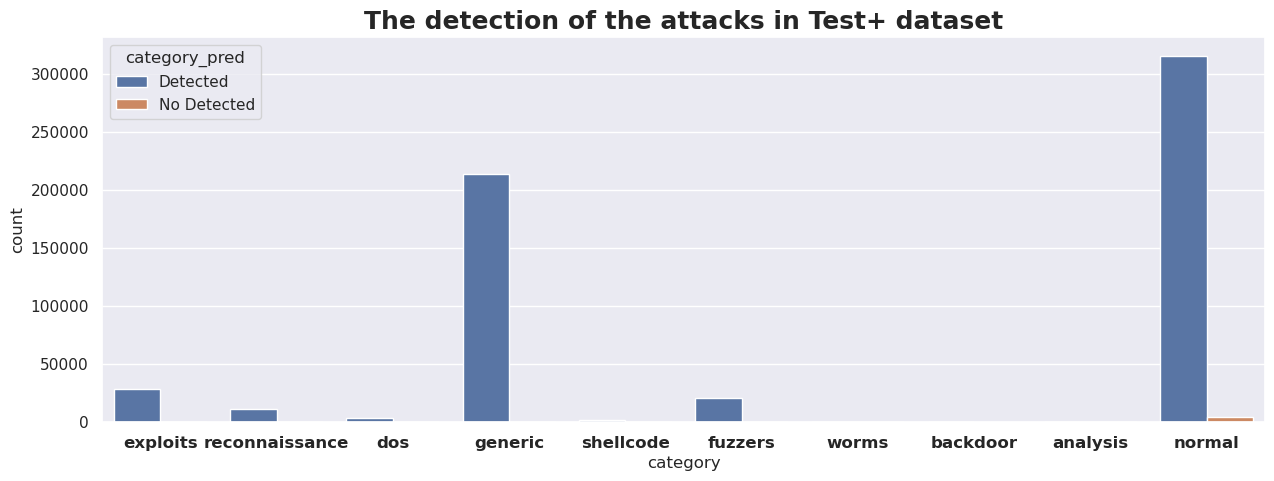

In [153]:
# Plotting target label distribution
plt.figure(figsize=(15,5))
sns.set_theme(style="darkgrid")
sns.countplot(x=data_plot['category'], data=data_plot, hue=data_plot['category_pred'])
plt.title('The detection of the attacks in Test+ dataset', weight='bold', fontsize='18')
plt.xticks(weight='bold', fontsize=12)
plt.show()

In [154]:
summary

,Traffic,Detected %,No Detected %,Detected Samples,No Detected Samples
0,Normal,98.562619,1.437381,315975,4608
1,Analysis,99.839228,0.160772,621,1
2,Backdoor,100.000000,0.000000,357,0
3,Fuzzers,98.452386,1.547614,21184,333
4,Shellcode,99.933819,0.066181,1510,1
5,Worms,98.850575,1.149425,172,2
6,Generic,99.998128,0.001872,213714,4
7,Exploits,99.862274,0.137726,28278,39
8,Reconnaissance,99.949384,0.050616,11848,6
9,DoS,99.844680,0.155320,3857,6


In [155]:
improve = pd.read_csv('../others/No_TransferLearningFull.csv')

In [156]:
improve['Detected %'] = summary['Detected %'] - improve['Detected %']
improve['Detected Samples'] = summary['Detected Samples'] - improve['Detected Samples']
del improve['No Detected %']
del improve['No Detected Samples']

improve.rename(columns = {'Detected %':'Detection Improvement %', 'Detected Samples':'Detected Samples Improvement'}, inplace = True)

In [157]:
improve

,Traffic,Detection Improvement %,Detected Samples Improvement
0,Normal,-0.004991,-16
1,Analysis,0.643087,4
2,Backdoor,0.280112,1
3,Fuzzers,0.469396,101
4,Shellcode,0.132363,2
5,Worms,0.000000,0
6,Generic,0.006551,14
7,Exploits,0.045909,13
8,Reconnaissance,0.008436,1
9,DoS,0.025887,1
